## Import libraries and load dataset

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import os
from pathlib import Path
import cv2
from cv2 import erode
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate, rescale
from tqdm import tqdm
import segmentation_models_pytorch as smp
import torch
from torch.nn.functional import interpolate
from skimage import io, color
import zipfile
from PIL import Image

In [ ]:
masks = []
images = []

In [ ]:
root = '/content/drive/MyDrive/Colab_Notebooks/tissue-segment'
for _, _, files in os.walk(root):
  files.sort()
  for i in range(440):
    ends = root + "/" + files[i]
    if ends.endswith("mask.jpg"):
      masks.append(cv2.imread(root + "/" + files[i]))
    else:
      images.append(cv2.cvtColor(cv2.imread(root + "/" + files[i]), cv2.COLOR_BGR2RGB))

In [ ]:
masks = np.array(masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
images = np.array(images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


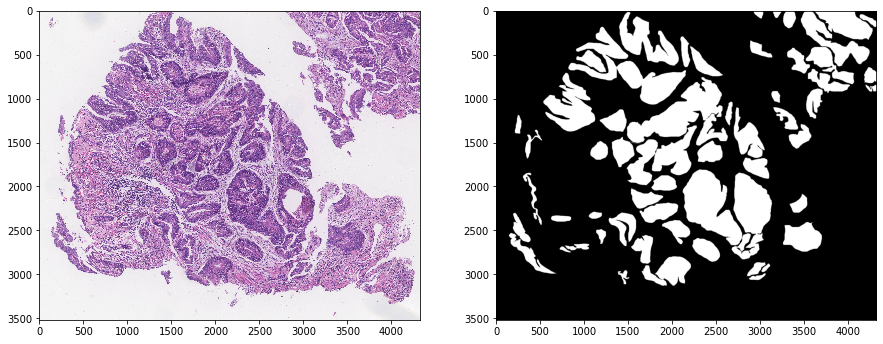

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(images[0], interpolation='none')
ax[1].imshow(masks[0])

## Data Augmentation


In [ ]:
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(self, images=None, masks=None, transforms=None) -> None:
        self.images_test = images_test
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images_test)

    def __getitem__(self, idx: int) -> dict:
        image = self.images_test[idx]

        result = {"image": image}

        if self.masks is not None:
            result["mask"] = self.masks[idx].mean(2).astype(int) // 255

        if self.transforms is not None:
            result = self.transforms(**result)
        return result

In [ ]:
import albumentations as albu
from albumentations.pytorch import ToTensor


def pre_transform(image_size: int = 224):
    return albu.Resize(224, 224, p=1)


def augmentations(image_size: int = 224):
    channel_augs = [
        albu.HueSaturationValue(p=0.5),
        albu.ChannelShuffle(p=0.5),
    ]

    result = [
        albu.OneOf(
            [albu.IAAAdditiveGaussianNoise(), albu.GaussNoise(),], p=0.5
        ),
        albu.OneOf(
            [
                albu.MotionBlur(blur_limit=3, p=0.7),
                albu.MedianBlur(blur_limit=3, p=1.0),
                albu.Blur(blur_limit=3, p=0.7),
            ],
            p=0.5,
        ),
        albu.OneOf(channel_augs),
        albu.OneOf(
            [albu.CLAHE(clip_limit=2), albu.IAASharpen(), albu.IAAEmboss(),],
            p=0.5,
        ),
        albu.RandomBrightnessContrast(
            brightness_limit=0.5, contrast_limit=0.5, p=0.5
        ),
        albu.RandomGamma(p=0.5),
        albu.OneOf([albu.MedianBlur(p=0.5), albu.MotionBlur(p=0.5)]),
        albu.RandomGamma(gamma_limit=(85, 115), p=0.5),
    ]
    return albu.Compose(result)


def post_transform():
    return albu.Compose([albu.Normalize(), ToTensor()])

In [ ]:
train_transformation = albu.Compose(
    [pre_transform(), augmentations(), post_transform()]
)

valid_transformation = albu.Compose(
    [pre_transform(), post_transform()]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


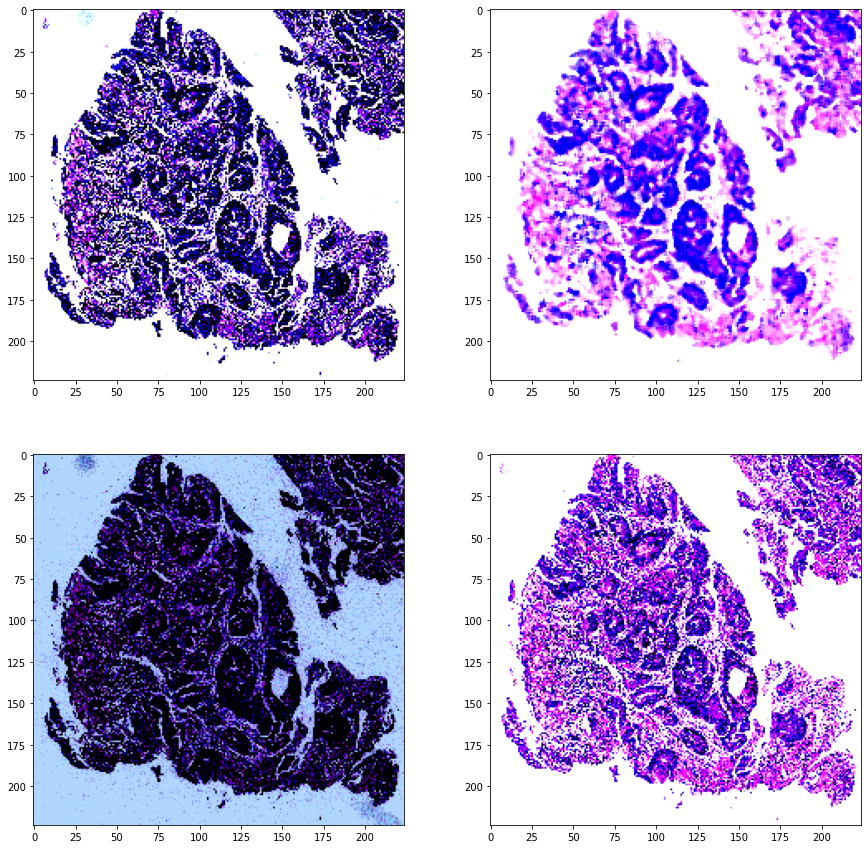

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    aug_image = train_transformation(image=images[0])["image"].permute(1, 2, 0).numpy()
    ax[i % 2][i // 2].imshow(aug_image)

In [ ]:
from torch.utils.data import DataLoader, random_split


batch_size = 8
num_workers = 4


indexes = np.arange(len(images_test))
np.random.shuffle(indexes)
train_indexes = indexes[:int(0.8 * len(images_test))]
valid_indexes = indexes[int(0.8 * len(images_test)):]

train=SegmentationDataset(
        images_test[valid_indexes], masks[valid_indexes], valid_transformation
    )
test=SegmentationDataset(
        images_test[valid_indexes], masks[valid_indexes], valid_transformation
    )

In [ ]:
list_train = []
for x in train:
  i = "image"
  m = "mask"
  list_train.append((x[i], x[m]))

In [ ]:
list_test = []
for x in test:
  i = "image"
  m = "mask"
  list_test.append((x[i], x[m]))

In [ ]:
trainDL = DataLoader(list_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

testDL = DataLoader(list_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Train model

## UNET

In [ ]:
ENCODER = "resnet18"
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["building"]
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'


In [ ]:
# Initiate UNet Model 

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

#Define Loss and Metrics to Monitor 
loss = smp.utils.losses.DiceLoss() + smp.utils.losses.BCELoss()
metrics = [
    smp.utils.metrics.Fscore(beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None),
    smp.utils.metrics.Accuracy(threshold=0.5, activation=None, ignore_channels=None),
    smp.utils.metrics.Recall(eps=1e-7, threshold=0.5, activation=None, ignore_channels=None),
    smp.utils.metrics.Precision(eps=1e-7, threshold=0.5, activation=None, ignore_channels=None),
]

# Define Optimizer (Adam in this case) and learning rate 
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters()),
])

# Define training epock 
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

# Define testing epoch 
test_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

# Train model for 30 epochs 
max_score = 0

for i in range(0, 30):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(trainDL)
    test_logs = test_epoch.run(testDL)
    
    if max_score < test_logs['fscore']:
        max_score = test_logs['fscore']
        torch.save(model, '/content/drive/MyDrive/Colab_Notebooks/models/best_model_unet_best.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

# Load saved model 
# best_model = torch.load('/content/drive/MyDrive/Colab_Notebooks/models/best_model_unet.pth')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]


Epoch: 0
valid: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s, dice_loss + bce_loss - 1.444, fscore - 0.3747, accuracy - 0.4573, recall - 0.9995, precision - 0.2325]
Model saved!

Epoch: 1
valid: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s, dice_loss + bce_loss - 1.415, fscore - 0.5937, accuracy - 0.8165, recall - 0.8283, precision - 0.4658]
Model saved!

Epoch: 2
valid: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s, dice_loss + bce_loss - 1.372, fscore - 0.5927, accuracy - 0.8336, recall - 0.7508, precision - 0.4915]

Epoch: 3
valid: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, dice_loss + bce_loss - 1.321, fscore - 0.6342, accuracy - 0.8621, recall - 0.7539, precision - 0.5479]
Model saved!

Epoch: 4
valid: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s, dice_loss + bce_loss - 1.271, fscore - 0.6546, accuracy - 0.8834, recall - 0.7051, precision - 0.6122]
Model saved!

Epoch: 5
valid: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s, dice_loss + bce_loss - 1.222, fscore - 0.6473, accuracy

## Visualize result

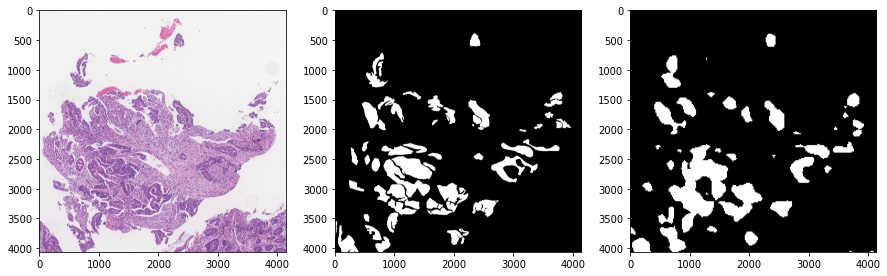

In [ ]:
pt_image = valid_transformation(image=images[1])["image"].unsqueeze(0).cuda()
model.eval()
pt_mask = torch.sigmoid(model(pt_image).detach().cpu())
pt_mask = interpolate(pt_mask, images[1].shape[:-1]).squeeze()
pt_mask=torch.where(pt_mask < 0.55, 0, 1)
example_mask = pt_mask.squeeze().numpy()

example_mask

_, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(images[1])
ax[1].imshow(masks[1])
ax[2].imshow(example_mask, cmap='gray')

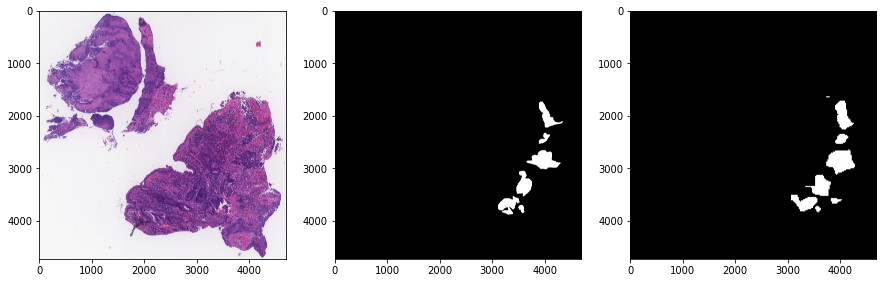

In [ ]:
pt_image = valid_transformation(image=images[40])["image"].unsqueeze(0).cuda()
model.eval()
pt_mask = torch.sigmoid(model(pt_image).detach().cpu())
pt_mask = interpolate(pt_mask, images[40].shape[:-1]).squeeze()
pt_mask=torch.where(pt_mask < 0.55, 0, 1)
example_mask = pt_mask.squeeze().numpy()

example_mask

_, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(images[40])
ax[1].imshow(masks[40])
ax[2].imshow(example_mask, cmap='gray')

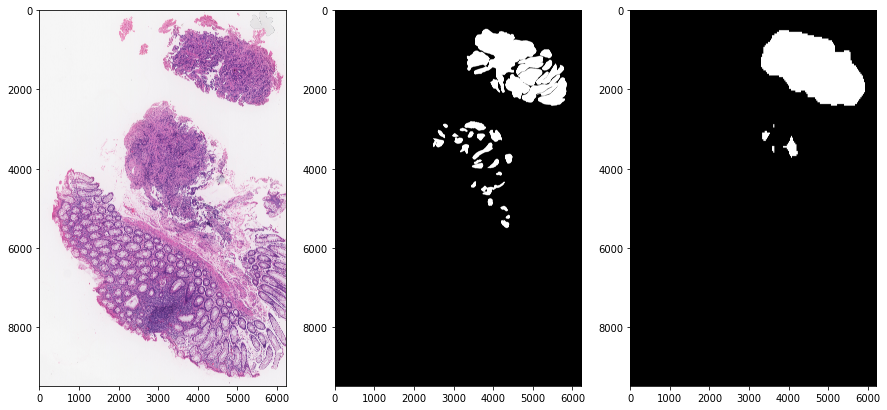

In [ ]:
pt_image = valid_transformation(image=images[10])["image"].unsqueeze(0).cuda()
model.eval()
pt_mask = torch.sigmoid(model(pt_image).detach().cpu())
pt_mask = interpolate(pt_mask, images[10].shape[:-1]).squeeze()
pt_mask=torch.where(pt_mask < 0.55, 0, 1)
example_mask = pt_mask.squeeze().numpy()

example_mask

_, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(images[10])
ax[1].imshow(masks[10])
ax[2].imshow(example_mask, cmap='gray')

## Save images

In [ ]:
root = '/content/drive/MyDrive/Colab_Notebooks/tissue-segment'
list_names = []
for _, _, files in os.walk(root):
  files.sort()
  for i in range(0,440):
    ends = root + "/" + files[i]
    if ends.endswith("mask.jpg") == True:
      list_names.append(ends)

In [ ]:
for i, v in enumerate(list_names):
  pt_image = valid_transformation(image=images[i])["image"].unsqueeze(0).cuda()
  model.eval()
  pt_mask = torch.sigmoid(model(pt_image).detach().cpu())
  pt_mask = interpolate(pt_mask, images[i].shape[:-1]).squeeze()
  example_mask = pt_mask.squeeze().numpy()

  img = Image.fromarray(np.uint8(example_mask * 255))
  thresh = 137.7
  fn = lambda x : 255 if x > thresh else 0
  img = img.convert('L').point(fn, mode='1')
  img.save(f'/content/drive/MyDrive/Colab_Notebooks/tissue-segment_pred/pred_{v[54:]}')

## TEST IMAGE

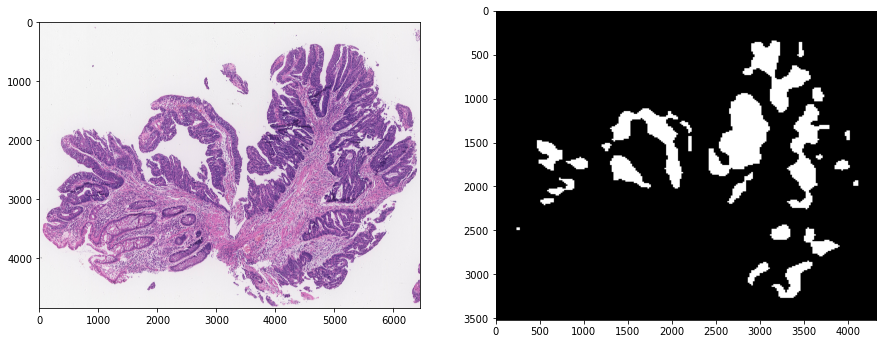

In [ ]:
pt_image = valid_transformation(image=images_test[0])["image"].unsqueeze(0).cuda()
model.eval()
pt_mask = torch.sigmoid(model(pt_image).detach().cpu())
pt_mask = interpolate(pt_mask, images[0].shape[:-1]).squeeze()
pt_mask=torch.where(pt_mask < 0.7, 0, 1)
example_mask = pt_mask.squeeze().numpy()

example_mask

_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(images_test[0])
ax[1].imshow(example_mask, cmap='gray')